# Lead Scoring - Case Study

### Problem Statement

X Education sells online courses using the leads that they get from several sources. Current lead conversion rate is only 30%, they want to improve this by identify potential leads that can be converted.

#### Import Libraries

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import math
import datetime as dt

import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

#pandas options:
pd.set_option('max_rows',500)
pd.set_option('max_columns',500)


#Statsmodels api
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#General - Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve


## 1. Data Understanding

#### Read data

In [2]:
#Read csv file
df = pd.read_csv('Leads.csv')

In [3]:
#Inspect the information about the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

#### Many categorical columns are present. Only few columns are numerical

In [4]:
#Look at first 5 rows
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [5]:
# Look at stats
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [6]:
#Print number of rows initially
print('Initial Number of Rows:',len(df))

Initial Number of Rows: 9240


## 2. Data Preparation

### 2.1 Missing Value Columns

In [7]:
#Function to get null percentages in all columns rounded to 4 decimals
def check_null(df):
    null_perc = (round( 100 * ( df.isnull().sum()/len(df) ), 4 ))
    return null_perc

In [8]:
#Check null percentages for the columns having nulls
null_perc=check_null(df)
null_perc[null_perc>0].sort_values(ascending=False)

Lead Quality                                     51.5909
Asymmetrique Profile Score                       45.6494
Asymmetrique Profile Index                       45.6494
Asymmetrique Activity Index                      45.6494
Asymmetrique Activity Score                      45.6494
Tags                                             36.2879
What matters most to you in choosing a course    29.3182
Lead Profile                                     29.3182
What is your current occupation                  29.1126
Country                                          26.6342
How did you hear about X Education               23.8853
Specialization                                   15.5628
City                                             15.3680
Page Views Per Visit                              1.4827
TotalVisits                                       1.4827
Last Activity                                     1.1147
Lead Source                                       0.3896
dtype: float64

#### Drop columns having more than 35% nulls

In [9]:
#Copy data to a new dataframe and work on it from now on, leaving the original data frame as is
df_leads = df.copy()

#Drop columns having more than 35% nulls
df_leads = df_leads.drop(columns=null_perc[null_perc > 35].index)

In [10]:
# Inspect datframe after dropping columns
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 31 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

#### Following 6 columns have been dropped due to high percentage of null : 
1. Lead Quality
2. Asymmetrique Profile Score
3. Asymmetrique Profile Index
4. Asymmetrique Activity Index
5. Asymmetrique Activity Score
6. Tags

### 2.2 Cleaning

#### Drop Prospect Id and Lead Number as they are unique identifiers

In [11]:
# Set Lead number as index before dropping it
df_leads = df_leads.set_index('Lead Number',drop=True)

#Drop Prospect ID
df_leads = df_leads.drop(columns=['Prospect ID'])

In [12]:
#Inspect the shape after dropping
df_leads.shape

(9240, 29)

#### Give the columns easy to handle and readable names without spaces

In [13]:
#Change column names to easy to handle and readable names
df_leads = df_leads.rename(columns={'Lead Origin':'Origin',
                         'Lead Source':'Source',
                         'Do Not Email':'NoEmail',
                         'Do Not Call':'NoPhone',
                         'Total Time Spent on Website':'TTSW',
                         'Page Views Per Visit':'PageViews',
                         'Last Activity':'LastActivity',
                         'How did you hear about X Education':'HeardThrough',
                         'What is your current occupation':'Occupation',
                         'What matters most to you in choosing a course':'Objective',
                         'Newspaper Article':'NewsPaperArticle',
                         'X Education Forums':'XForum',
                         'Digital Advertisement':'DigitalAdv',
                         'Through Recommendations':'Referred',
                         'Receive More Updates About Our Courses':'Updates',
                         'Update me on Supply Chain Content':'SCUpdates',
                         'Get updates on DM Content':'DMUpdates',
                         'Lead Profile':'ProfLevel',
                         'I agree to pay the amount through cheque':'Cheque',
                         'A free copy of Mastering The Interview':'FreeCopy',
                         'Last Notable Activity':'LastNotableAct',
                        })

#### Print number of unique values in each column

In [14]:
#Check number of unique elements in each column
df_leads.nunique()

Origin                 5
Source                21
NoEmail                2
NoPhone                2
Converted              2
TotalVisits           41
TTSW                1731
PageViews            114
LastActivity          17
Country               38
Specialization        19
HeardThrough          10
Occupation             6
Objective              3
Search                 2
Magazine               1
NewsPaperArticle       2
XForum                 2
Newspaper              2
DigitalAdv             2
Referred               2
Updates                1
SCUpdates              1
DMUpdates              1
ProfLevel              6
City                   7
Cheque                 1
FreeCopy               2
LastNotableAct        16
dtype: int64

#### There are many categorical columns and few continuous columns. Separate them for easy handling

#### Classify columns

In [15]:
#Divide columns into continuous(numerical), having multiple categories (more than 2 values),  Single category and Two categories

#Continuous Variables
cont_cols = ['TotalVisits', 'TTSW', 'PageViews']

#Categorical Variables with multiple categories
multi_cat_cols = ['Origin', 'Source', 'LastActivity', 'Country','Specialization', 'HeardThrough', 'Occupation', 'Objective', 'ProfLevel', 'City','LastNotableAct']

# Columns with only one category
single_cat_cols = ['Magazine', 'Updates', 'SCUpdates', 'DMUpdates', 'Cheque']

# Columns with two categories
binary_cols = ['NoEmail', 'NoPhone', 'Search', 'NewsPaperArticle', 'XForum', 'Newspaper', 'DigitalAdv', 'Referred', 'FreeCopy']

In [16]:
#Just to verify total number of columns in these lists are 28 (Target column Converted is not in these lists)
sum((len(multi_cat_cols), len(cont_cols), len(single_cat_cols), len(binary_cols)))

28

### 2.3 Outliers

#### Check outliers using box plots

In [17]:
#Function to draw box plots in a data frame for the given set of columns
def draw_box_plots(df, cols):
    plt.figure(figsize=(15,4))

    i=1
    for col in cols:
        plt.subplot(1,3,i)
        #Plot box plot
        sns.boxplot(y=df[col])
        i +=1

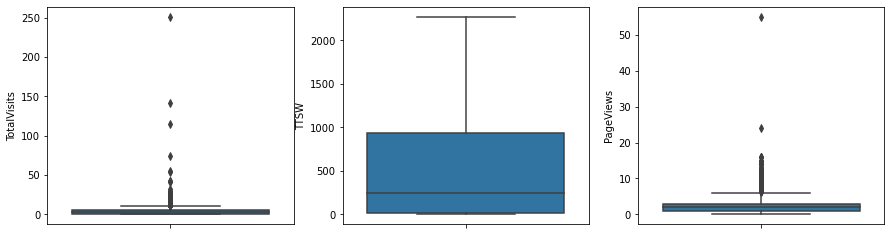

In [18]:
#Box plots fot continuos columns
draw_box_plots(df_leads, cont_cols)

In [19]:
#Fetch and Inspect quantile values
df_leads[['TotalVisits','PageViews']].quantile([.25,.5,.75,.9,.95,.99, .995, .999, .9999,1])

,TotalVisits,PageViews
0.2500,1.000,1.0000
0.5000,3.000,2.0000
0.7500,5.000,3.0000
0.9000,7.000,5.0000
0.9500,10.000,6.0000
0.9900,17.000,9.0000
0.9950,21.000,11.0000
0.9990,31.796,14.4490
0.9999,150.878,26.7838
1.0000,251.000,55.0000


#### There are outliers in Total Visits and Page Views. Cap them to .999th quantile values

In [20]:
#Columns to be capped
cols = ['TotalVisits','PageViews']

for col in cols:
    #Get 99th quantile value
    q_999 = df_leads[col].quantile(.999)
    
    #Set values more than 99th quantile to 99th quantile
    df_leads.loc[df_leads[col] > q_999, col] = q_999

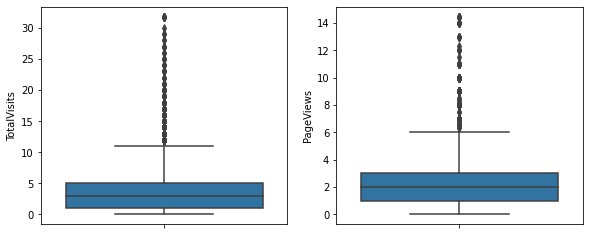

In [21]:
#Draw Box plots after capping to check the data
draw_box_plots(df_leads, cols)

#### Now, there are no outliers that are standing out clearly 

### 2.4 Prepare Categorical Variables

### 2.4.1 Single Category Columns

In [22]:
# Check the values counts in columns with single category
df_leads[single_cat_cols].apply(pd.value_counts)

,Magazine,Updates,SCUpdates,DMUpdates,Cheque
No,9240,9240,9240,9240,9240


#### Drop columns with only a single value. They will not help model.

In [23]:
# All These columns have only one category and doesn't need to part of the model. Hence drop them 
df_leads = df_leads.drop(columns=single_cat_cols)

### 2.4.2 Binary Columns

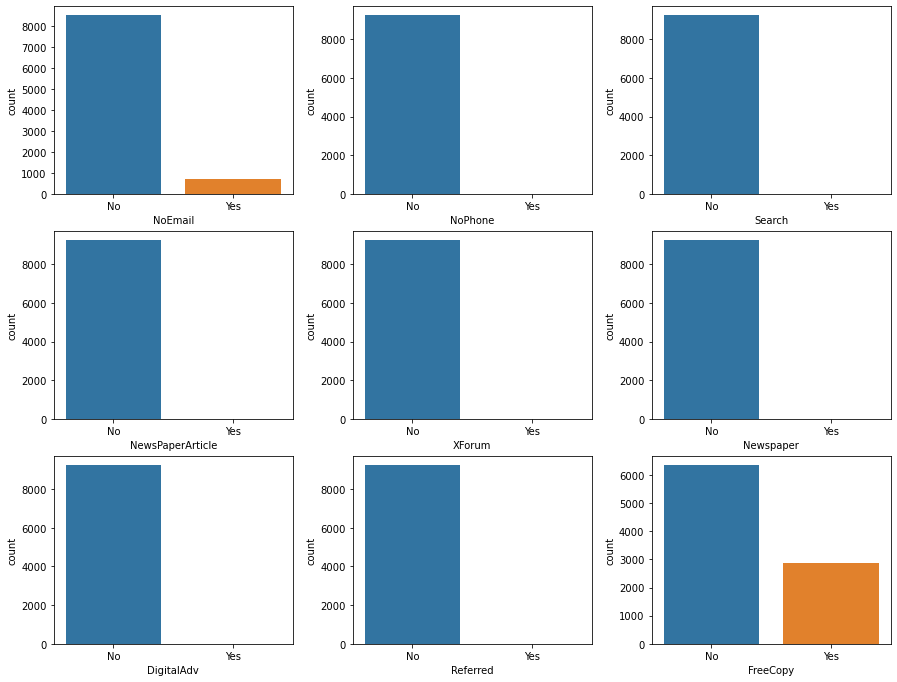

In [24]:
# Check for binary variables with - Yes and No

plt.figure(figsize = [15,20])
for i, col in enumerate(binary_cols):
    plt.subplots_adjust(hspace=0.20,wspace=0.25)
    plt.subplot(5,3,i+1)
    sns.countplot(df_leads[col])
    
plt.show()

#### All columns except for NoEmail and FreeCopy have only majority of values as No. Yes rows are very less. Since there is not much varince in these columns, drop these. They will be able to help the model learn 

In [25]:
#Drop all columns except for NoEmail and FreeCopy.
binary_cols_drop = ['NoPhone', 'Search', 'NewsPaperArticle', 'XForum', 'Newspaper', 'DigitalAdv', 'Referred']
df_leads = df_leads.drop(columns=binary_cols_drop)

#Left Out Columns with Two Values
binary_cols = ['NoEmail', 'FreeCopy']

### 2.4.3 Multiple Category Columns

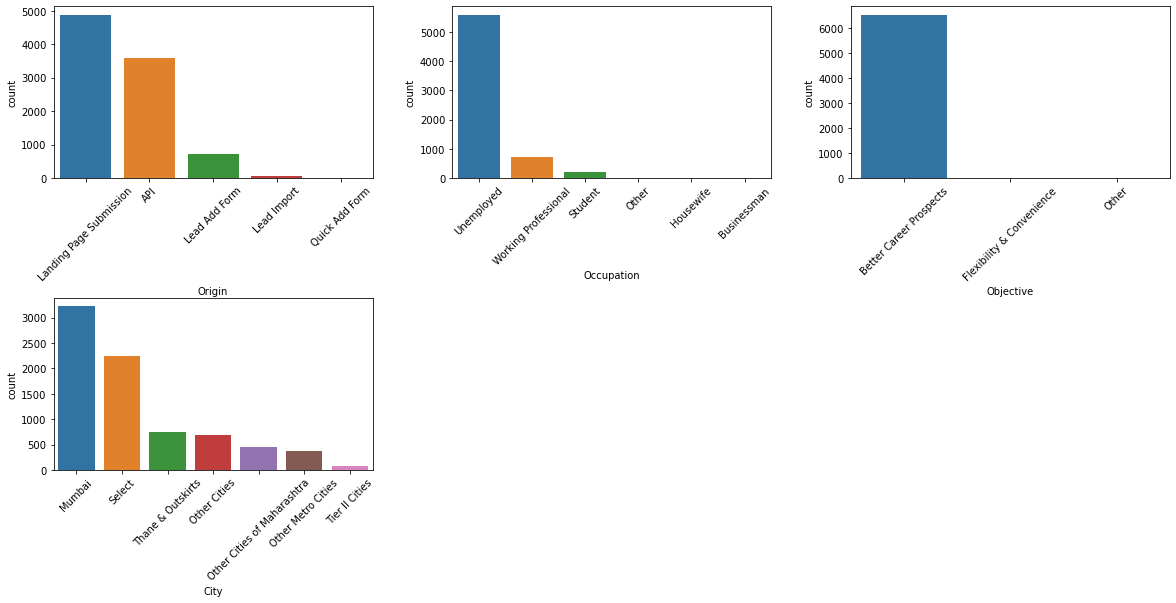

In [26]:
# Check for the variables with multiple categories - first set

cols = ['Origin', 'Occupation', 'Objective', 'City']

plt.figure(figsize = [20,30])
for i, col in enumerate(cols):
    plt.subplots_adjust(hspace=0.70,wspace=0.25)
    plt.subplot(6,3,i+1)
    sns.countplot(df_leads[col], order=df_leads[col].value_counts().index)
    plt.xticks(rotation = 45)
    
plt.show()

#### Observations:
1. Objective is highly skewed with one category - Better Career Prospects. Drop it
2. Other variables are not so skwed with a single category. Hence retain them

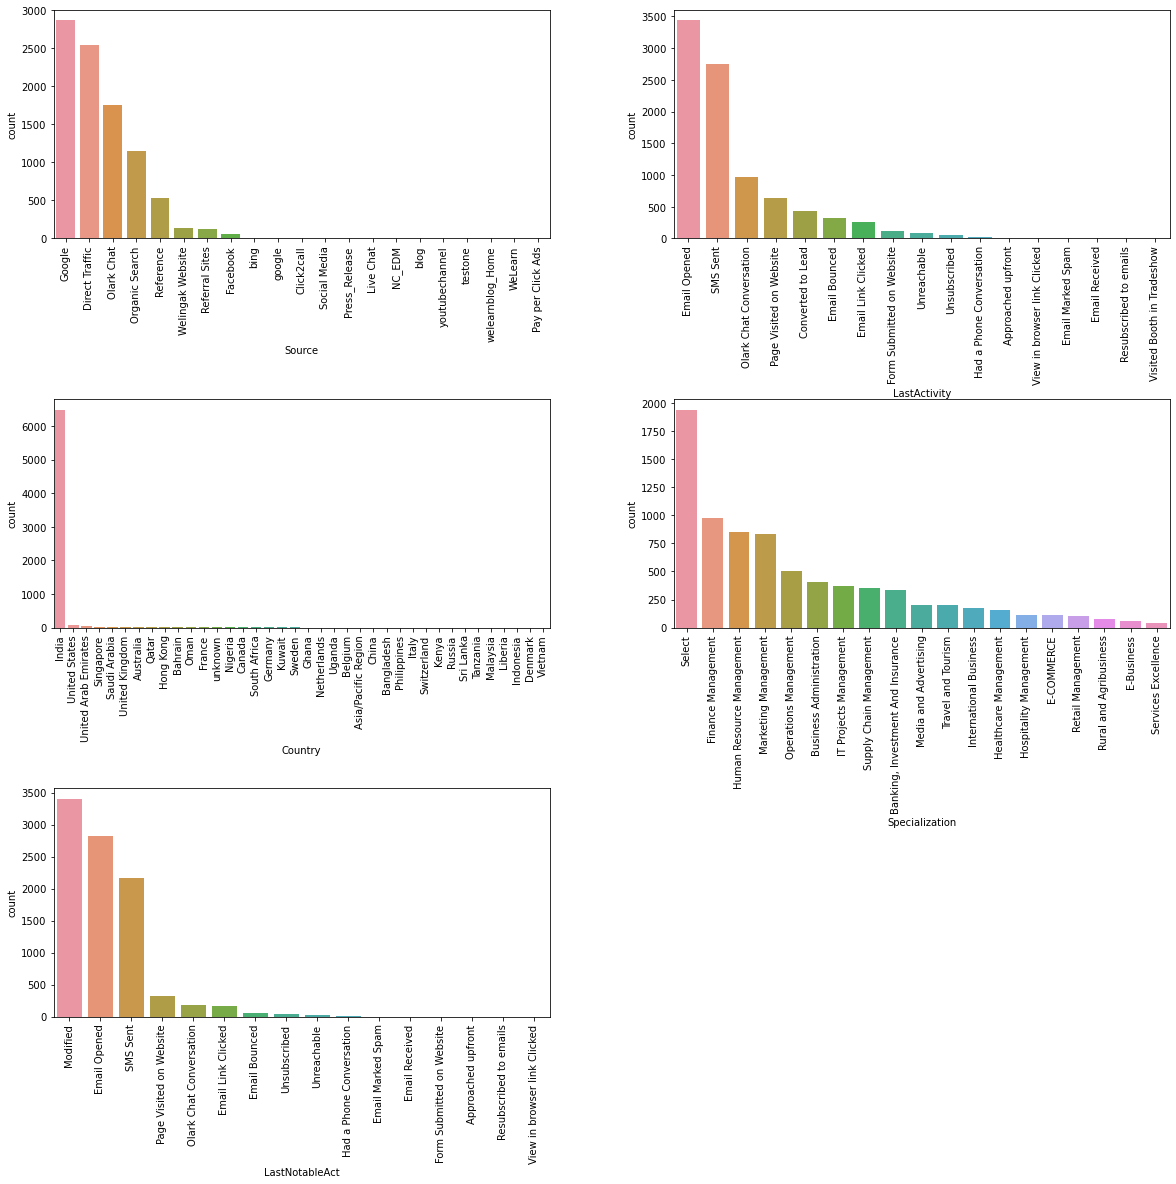

In [27]:
# Check the next set of multiple categories variables
# cols = ['Source','LastActivity','Country', 'Specialization', 'Tags','LastNotableAct']
cols = ['Source','LastActivity','Country', 'Specialization','LastNotableAct']

plt.figure(figsize = [20,40])
for i, col in enumerate(cols):
    plt.subplots_adjust(hspace=0.70,wspace=0.25)
    plt.subplot(6,2,i+1)
    sns.countplot(df_leads[col], order=df_leads[col].value_counts().index)
    plt.xticks(rotation = 90)
    

#### Observations:
1. Country is highly skewed with single category of India. Drop it.
2. Some categorical columns have few categories with very less number of rows. Move the categories with less than 0.5% of rows to a separate bucket called Others.

#### Drop Skewed Categorical columns

In [28]:
cols=['Country','Objective']
#Drop these columns
df_leads = df_leads.drop(columns=cols)

#Remove these columns from multi_cat_cols list too
multi_cat_cols = list(set(multi_cat_cols) - set(cols))

#### Move categories with less than 0.5% of rows in each categorical column to 'Other' bucket
This reduces number of categories in each categorical columns

In [29]:
#Define the threshold
threshold = 0.5
cols = multi_cat_cols

#Iterate through categorical columnbs
for col in cols:
    #Get counts of each value in a columns 
    val_cnts = round(df_leads[col].value_counts(normalize=True)*100, 2)
    
    #List to store categories of categorical columns having less than threshold number of records 
    vals_lessthan_threshold = val_cnts[val_cnts <= threshold].index
    for val in vals_lessthan_threshold:
        #Set the values with less than threshold number of records to Other 
        df_leads[col] = df_leads[col].replace({val:'Other'})

In [30]:
#Inspect unique value counts after dropping these columns
df_leads[multi_cat_cols].nunique()

Specialization    19
HeardThrough       8
LastActivity      11
ProfLevel          5
LastNotableAct     9
City               7
Occupation         4
Origin             5
Source             9
dtype: int64

#### Number of categories have reduced significantly now. However, they are categories with only few records which will not have much impact on the model

### 2.4.4 Handle 'Select' Category

In [31]:
#Print the number of records in all category columns with value as 'Select'.
df_leads[multi_cat_cols].apply(pd.value_counts).loc['Select'].fillna(0)

Specialization    1942.0
HeardThrough      5043.0
LastActivity         0.0
ProfLevel         4146.0
LastNotableAct       0.0
City              2249.0
Occupation           0.0
Origin               0.0
Source               0.0
Name: Select, dtype: float64

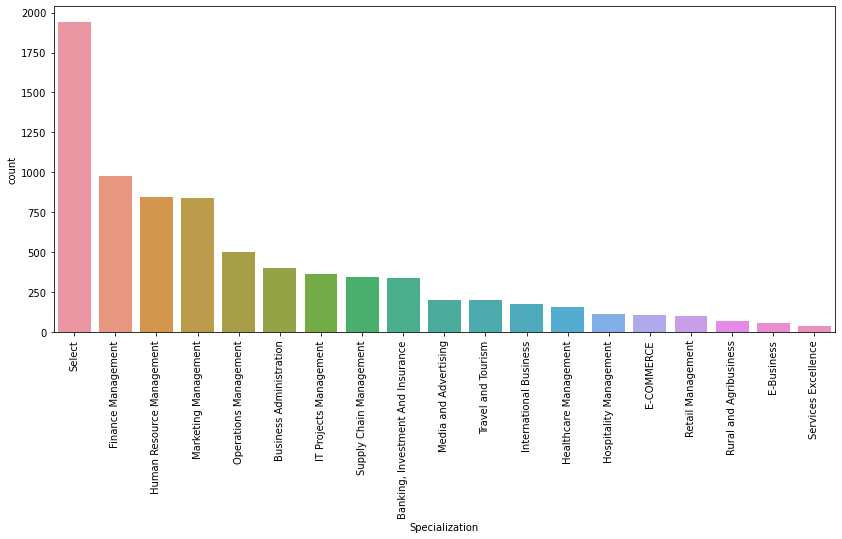

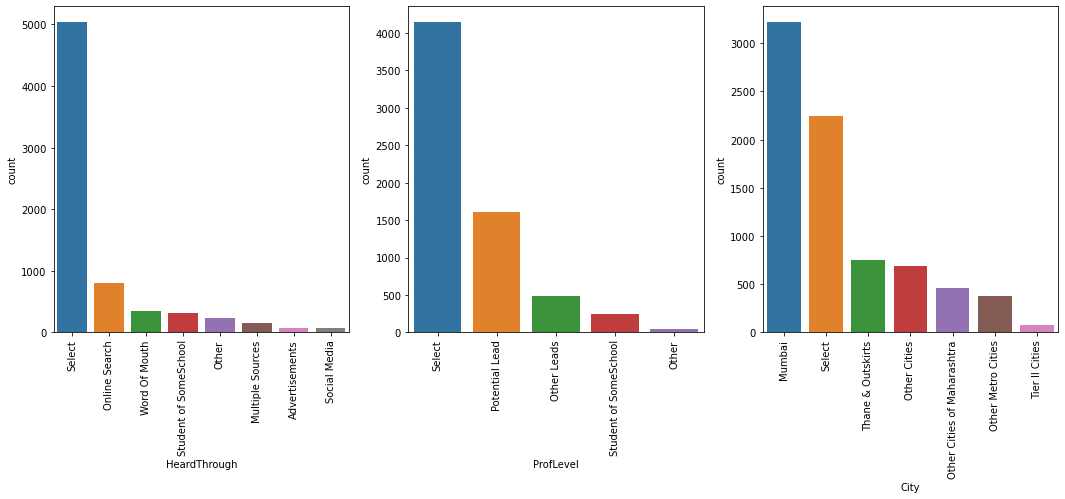

In [32]:
#List of columns with value 'Select' in them
cols_with_select = ['Specialization','HeardThrough','ProfLevel','City']

#Plot Specilization separately as it has many categories
plt.figure(figsize=(14,6))

sns.countplot(x=df_leads['Specialization'], order=df_leads['Specialization'].value_counts().index)
plt.xticks(rotation =90)
plt.show()

#Plot Remaining columns with select values
cols_with_select.remove('Specialization')
plt.figure(figsize=(18,6))


i=1
for col in cols_with_select:
    plt.subplot(1,3,i)
    sns.countplot(x=df_leads[col], order=df_leads[col].value_counts().index)
    plt.xticks(rotation =90)
    i+=1

#### Handling rows with value as 'Select': 
1. Specialization - Replace Select with Other
2. HearsThrough - Replace Select with Other which is an existing category
3. ProfLevel - Replace with null as this column seems to be set by someone manually
4. City - Replace Select with Other Cities which is an existing category

In [33]:
#Replace all select values with appropriate values mentioned above
df_leads['Specialization'] = df_leads['Specialization'].replace({'Select':'Other'})
df_leads['HeardThrough'] = df_leads['HeardThrough'].replace({'Select':'Other'})
df_leads['ProfLevel'] = df_leads['ProfLevel'].replace({'Select':np.nan})
df_leads['City'] = df_leads['City'].replace({'Select':'Other Cities'})

### 2.5 Handle Missing Data

In [34]:
#Check null value counts in all columns
null_perc = check_null(df_leads)

#Print only columns having nulls in descending order 
null_perc[null_perc>0].sort_values(ascending = False)

ProfLevel         74.1883
Occupation        29.1126
HeardThrough      23.8853
Specialization    15.5628
City              15.3680
PageViews          1.4827
TotalVisits        1.4827
LastActivity       1.1147
Source             0.3896
dtype: float64

#### Observations and actions from missing values counts:
1. ProfLevel have too many nulls. Drop this column
2. PageViews, TotalVisits, LastActivity and Source have very few null rows, leave them as is. They will be dropped.
3. All other columns have good number of nulls, set them all to Unknown

In [35]:
#Categorical columns having null values that needs to be set to unknown
null_multi_cat_cols = ['Specialization', 'Occupation', 'City', 'HeardThrough']

In [36]:
#Set null values of these categorical columns to Unknown
for col in null_multi_cat_cols:
    df_leads[col]=df_leads[col].fillna('Unknown')

In [37]:
#Drop ProfLevel as it has many nulls and it is a column prepared by sales team.
columns=['ProfLevel']

# Drop the columns
df_leads = df_leads.drop(columns=columns)

#Remove these columns from multi_cat_cols list too
multi_cat_cols = list(set(multi_cat_cols) - set(columns))

#### Drop remaining missing values

In [38]:
#Drop remaining nulls from the data set
df_leads = df_leads.dropna()

In [39]:
#Check null value counts in all columns after handling them
check_null(df_leads)

Origin            0.0
Source            0.0
NoEmail           0.0
Converted         0.0
TotalVisits       0.0
TTSW              0.0
PageViews         0.0
LastActivity      0.0
Specialization    0.0
HeardThrough      0.0
Occupation        0.0
City              0.0
FreeCopy          0.0
LastNotableAct    0.0
dtype: float64

#### There are no missing values now

In [40]:
#Print retained data percentage after cleaning
print ( 'Retained number of rows percentage,', round( 100*len(df_leads)/len(df), 2) )

Retained number of rows percentage, 98.2


#### We have retained about 98% of rows after cleaning

## 3. Exploratory Data Analysis (EDA)

### 3.1 Data Imbalance

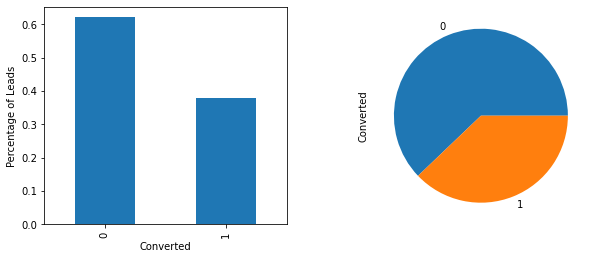

In [41]:
#Plot Converted vs Non Converted leads by their percentages
plt.figure(figsize=[10,4])
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)

#Bar graph
df_leads['Converted'].value_counts(normalize = True).plot.bar()
plt.xlabel("Converted")
plt.ylabel("Percentage of Leads")
plt.subplot(1,2,2)

#Pie Chart
df_leads['Converted'].value_counts(normalize = True).plot.pie()
plt.show()

#### Observation:
Impbalance is not very bad. Hence we can continue with further steps in the process

### 3.1 Univariate Analysis

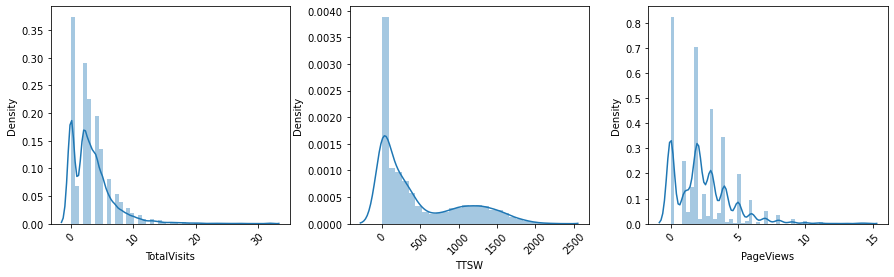

In [42]:
#Plot distribution of continuous variables
plt.figure(figsize=[15,4])
plt.subplots_adjust(hspace=0.30,wspace=0.25)

#Iterate through continuous variables
for i,col in enumerate(cont_cols):
    plt.subplot(1,3,i+1)
    #Use distplot to plot distribution
    sns.distplot(df_leads[col].dropna(),hist=True)
    plt.xticks(rotation=45)
    plt.ylabel("Density")
    
plt.show()

#### Observations:
1. Total Time Spent and Total Visits are skewed to the right side
2. Page Views are randomly distributed with several peaks at different palces

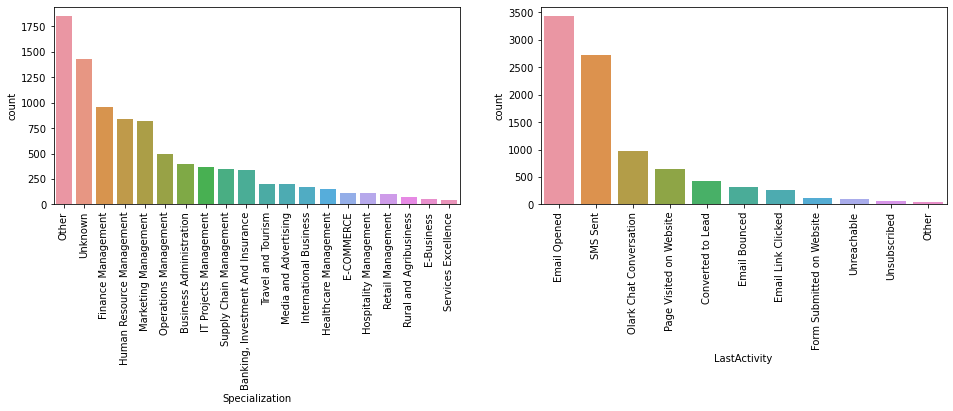

In [43]:
#Plot distribution of categories - set 1
plt.figure(figsize=(16,8))

#Count plot for Specialization
plt.subplot(2,2,1)
sns.countplot(x=df_leads.Specialization, order=df_leads.Specialization.value_counts().index)
plt.xticks(rotation=90)

#Count plot for LastActivity
plt.subplot(2,2,2)
sns.countplot(df_leads.LastActivity, order=df_leads.LastActivity.value_counts().index)
plt.xticks(rotation=90)
plt.show()

#### Observations:
1. Most of the Specialization are either 'Other' or 'Unknown'   
2. Most of Student's last activity is Email Opened.

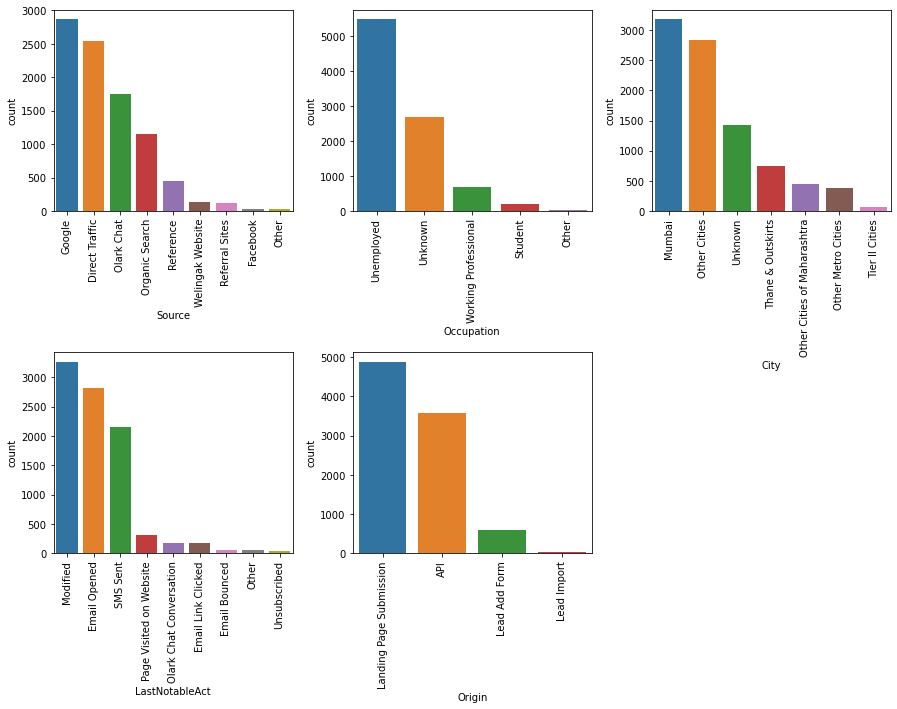

In [44]:
#Plot distribution of categories - set 2
cols = ['Source', 'Occupation', 'City', 'LastNotableAct', 'Origin']
plt.figure(figsize=(15, 10) )

i=1
#Iterate through columns
for col in cols:
    plt.subplots_adjust(hspace=0.70,wspace=0.25)
    plt.subplot(2,3,i)
    
    #Use countplot to plot distrbution of categories
    sns.countplot(x =df_leads[col], order=df_leads[col].value_counts().index)
    plt.xticks(rotation = 90)
    i +=1

#### Observations:
1. Google Search is a major source. Facebook is a source for very few leads. 
2. Most of the leads are unemployed. Very few students are leads
3. Around 35% of leads are from Mumbai
4. Last Notabale activity by most of the leads is Modified and Email Opened
5. Half of the leads are originated from Landing Page Submission while another major portion of leads is through API 

### 3.2 Bivariate Analysis

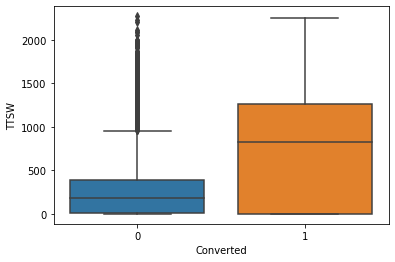

In [45]:
#Draw a box plot for Total Spent on website vs Converted
sns.boxplot(y='TTSW', x='Converted', data = df_leads)
plt.show()

#### When the time spent on website is more, they are most likely to get converted

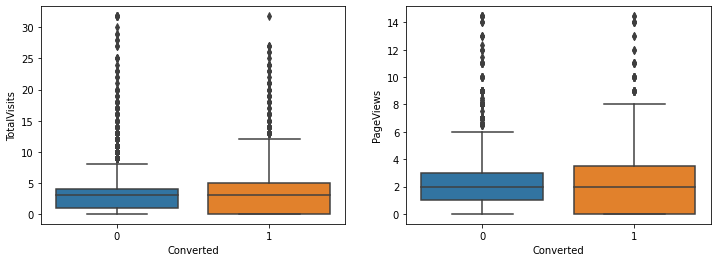

In [46]:
plt.figure(figsize=(12,4))

#Draw a box plot for Total Visits and Page Views vs Converted
plt.subplot(1,2,1)
sns.boxplot(y='TotalVisits', x='Converted', data = df_leads)

plt.subplot(1,2,2)
sns.boxplot(y='PageViews', x='Converted', data = df_leads)

#### Total Visits and Page Views doesn't seem to have much impact on conversion

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

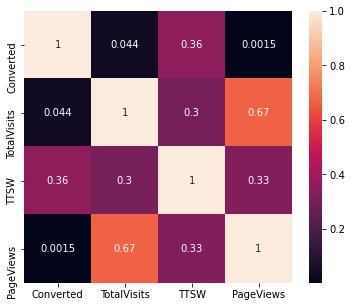

In [47]:
plt.figure(figsize=(6,5))

#Draw Heatmap of correlations
sns.heatmap(df_leads.corr(),annot=True)
plt.yticks(rotation=90)

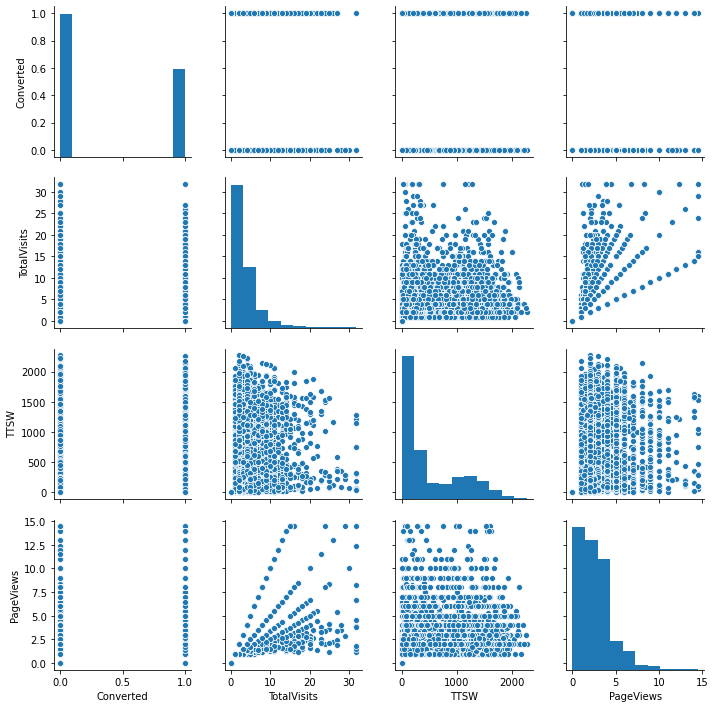

In [48]:
#Pair Plots to check Correlations
sns.pairplot(df_leads)

#### Onservations from Heatmap and Pairplots:
1. Total Visits and Page Views are linearly correlated which is expected.
2. Conversion is slightly correlated with Total Time Spent on Website, though this is not a strong correlation 
3. All other combinations do not have linear relationship among them

### Inspect Conversion Rate by each category in all categorical columns

In [49]:
#Create a new Data frame to have a categorical column 
# Appended by specific category value and Conversion rate (i.e Mean of Converted column)
#This is to plot all categories in one go
df_group = pd.DataFrame(columns=['Category', 'Converted'])

#Do this for all categorical columns
cols = multi_cat_cols+binary_cols    

#For every categorical column, calculate the conversion rate in a loop
for col in cols:
    #Consolidate by each column
    df1 = pd.DataFrame(columns=['Category','Converted'])
    g1 = df_leads.groupby(col).mean()['Converted']
    df1[['Category','Converted']]=pd.Series.to_frame(g1).reset_index()
    
    #Name the category as column name appended by each category in it
    df1['Category'] = col + ' (' + df1['Category'] +')'

    #Append categories of each column with conversion rate to the main dataframe
    df_group = pd.concat([df_group,df1])

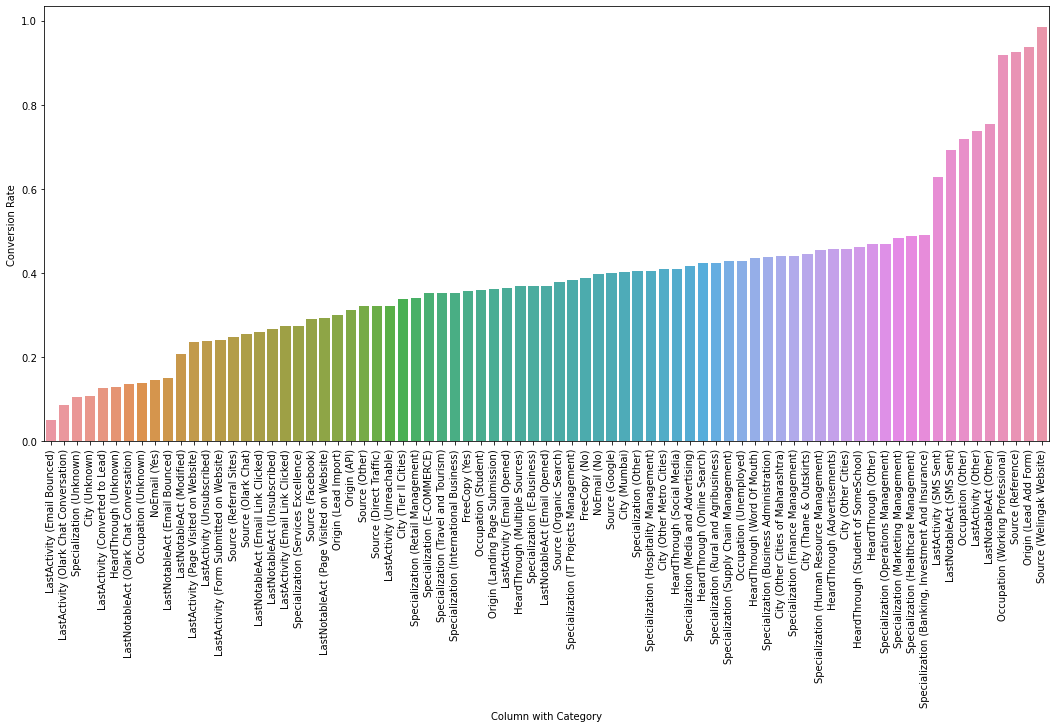

In [50]:
plt.figure(figsize=(18,8))

# Plot the conversion rate of all categories in one go
sns.barplot(x='Category', y='Converted', data=df_group.sort_values(by='Converted'))
plt.xticks(rotation=90)
plt.ylabel('Conversion Rate')
plt.xlabel('Column with Category')
plt.show()

#### Observations: 
1. Some of the columns with specific values seems to result in high conversion. To name a few:
        'Source - Welingak Website'
        'Origin - Lead Add Form'
        'Source - Reference'
        'Occupation - Working Professional'
        
2. Some of the columns with specific values seems to result in very low conversion. Few of them are:
        'Last Activity - Email Bounced', 
        'Last Activity - Olark Chat Conversation', 
        'Specialization - Unknown', 
        'City - Unknonwn', 


## 4. Data Preparation

### 4.1 Create Dummy Variables

In [51]:
#Get Dummy variables for all categorical variable columns
df_leads = pd.get_dummies(data = df_leads, columns=multi_cat_cols, drop_first=True)

In [52]:
#For categorical columns with 2 values, Set Yes and No to 1 and 0
df_leads[binary_cols] = df_leads[binary_cols].replace({'Yes':1, 'No':0})

In [53]:
#Inspect the dataframe after dummy variable creation
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 660737 to 579533
Data columns (total 71 columns):
NoEmail                                     9074 non-null int64
Converted                                   9074 non-null int64
TotalVisits                                 9074 non-null float64
TTSW                                        9074 non-null int64
PageViews                                   9074 non-null float64
FreeCopy                                    9074 non-null int64
Specialization_Business Administration      9074 non-null uint8
Specialization_E-Business                   9074 non-null uint8
Specialization_E-COMMERCE                   9074 non-null uint8
Specialization_Finance Management           9074 non-null uint8
Specialization_Healthcare Management        9074 non-null uint8
Specialization_Hospitality Management       9074 non-null uint8
Specialization_Human Resource Management    9074 non-null uint8
Specialization_IT Projects Management       9074 n

In [54]:
df_leads.shape

(9074, 71)

In [55]:
df_leads.head()

,NoEmail,Converted,TotalVisits,TTSW,PageViews,FreeCopy,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Other,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,HeardThrough_Multiple Sources,HeardThrough_Online Search,HeardThrough_Other,HeardThrough_Social Media,HeardThrough_Student of SomeSchool,HeardThrough_Unknown,HeardThrough_Word Of Mouth,LastActivity_Email Bounced,LastActivity_Email Link Clicked,LastActivity_Email Opened,LastActivity_Form Submitted on Website,LastActivity_Olark Chat Conversation,LastActivity_Other,LastActivity_Page Visited on Website,LastActivity_SMS Sent,LastActivity_Unreachable,LastActivity_Unsubscribed,LastNotableAct_Email Link Clicked,LastNotableAct_Email Opened,LastNotableAct_Modified,LastNotableAct_Olark Chat Conversation,LastNotableAct_Other,LastNotableAct_Page Visited on Website,LastNotableAct_SMS Sent,LastNotableAct_Unsubscribed,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Occupation_Student,Occupation_Unemployed,Occupation_Unknown,Occupation_Working Professional,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,Source_Facebook,Source_Google,Source_Olark Chat,Source_Organic Search,Source_Other,Source_Reference,Source_Referral Sites,Source_Welingak Website
Lead Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
660737,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
660728,0,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
660727,0,1,2.0,1532,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
660719,0,0,1.0,305,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
660681,0,1,2.0,1428,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0


#### Now, all columns are converted to numerical values. We have 71 columns

### 4.2 Split Data

In [56]:
#X - all columns except target column
X = df_leads.drop(columns='Converted')

#y - Target column alone
y = df_leads['Converted']

In [57]:
#Split data into 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [58]:
#Inspect X_train after the split
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7259 entries, 658852 to 605638
Data columns (total 70 columns):
NoEmail                                     7259 non-null int64
TotalVisits                                 7259 non-null float64
TTSW                                        7259 non-null int64
PageViews                                   7259 non-null float64
FreeCopy                                    7259 non-null int64
Specialization_Business Administration      7259 non-null uint8
Specialization_E-Business                   7259 non-null uint8
Specialization_E-COMMERCE                   7259 non-null uint8
Specialization_Finance Management           7259 non-null uint8
Specialization_Healthcare Management        7259 non-null uint8
Specialization_Hospitality Management       7259 non-null uint8
Specialization_Human Resource Management    7259 non-null uint8
Specialization_IT Projects Management       7259 non-null uint8
Specialization_International Business       7259 n

### 4.3 Scaling

In [59]:
#Stats for continuous variables
X_train[cont_cols].describe()

,TotalVisits,TTSW,PageViews
count,7259.000000,7259.000000,7259.000000
mean,3.401208,484.494283,2.369058
std,3.536123,546.497535,2.090826
min,0.000000,0.000000,0.000000
25%,1.000000,9.000000,1.000000
50%,3.000000,247.000000,2.000000
75%,5.000000,921.000000,3.330000
max,31.796000,2272.000000,14.449000


In [60]:
# Instantiate scaler
scaler = MinMaxScaler()

# Fit and transform continuous numeric columns using the scaler
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])

In [61]:
#Stats for continuous variables after scaling
X_train[cont_cols].describe()

,TotalVisits,TTSW,PageViews
count,7259.000000,7259.000000,7259.000000
mean,0.106970,0.213246,0.163960
std,0.111213,0.240536,0.144704
min,0.000000,0.000000,0.000000
25%,0.031450,0.003961,0.069209
50%,0.094351,0.108715,0.138418
75%,0.157252,0.405370,0.230466
max,1.000000,1.000000,1.000000


#### Continuous variables are scaled as we can see they are distributed between 0 and 1

## 5. Feature Selection

### 5.1 Feature Selection using RFE

In [62]:
#Instantiate logistic regression model
lr = LogisticRegression()

#Fit RFE to select 20 columns
rfe = RFE(lr, 20)

#Fit RFE with train data
rfe = rfe.fit(X_train, y_train)

In [63]:
#Columns selected by RFE
sel_cols = X_train.columns[rfe.support_]

#Print them
sel_cols

Index(['NoEmail', 'TotalVisits', 'TTSW', 'PageViews', 'Specialization_Other',
       'Specialization_Unknown', 'LastActivity_Email Opened',
       'LastActivity_Other', 'LastActivity_SMS Sent',
       'LastActivity_Unsubscribed', 'LastNotableAct_Modified',
       'LastNotableAct_Olark Chat Conversation', 'LastNotableAct_Other',
       'Occupation_Unknown', 'Occupation_Working Professional',
       'Origin_Landing Page Submission', 'Origin_Lead Add Form',
       'Source_Olark Chat', 'Source_Reference', 'Source_Welingak Website'],
      dtype='object')

### 5.2 Mannual Selection of Features

In [64]:
#Function to build a logistic regression model using statsmodel api
#Takes input data frame, target variable and list of columns to be selected from input dataframe as input
def build_model(X_, y_, columns):
    #Add Constant 
    X_sm = sm.add_constant(X_[columns])

    #Instantiate model
    lr_ = sm.GLM(y_, X_sm, family=sm.families.Binomial())

    #Fit Model
    model = lr_.fit()

    #Print Summary
    print(model.summary())
    return X_sm, model

In [65]:
#Function to predict values using the mode;
#Takes the model, input variables with constant actual taget and cutoff as input
def make_pred(model, X_sm, actual, cutoff ):
    #Predict values
    pred = model.predict(X_sm)
    pred = pred.values.reshape(-1)
    
    #Create a data frame with Converted, Probability, Lead Number and Predicted Converted variables
    df_pred = pd.DataFrame({'Converted': actual.values, 'Conversion_Prob':pred})
    df_pred['LeadNumber'] = actual.index
    
    #Predict using probability and cutoff
    df_pred['Converted_Pred'] = df_pred['Conversion_Prob'].map(lambda x: 1 if x > cutoff else 0)
        
    return df_pred

In [66]:
#Function to calculate most commonly used metrics and print them
#Takes the predicted dataframe and only_acc as input. If only_acc is true, prints only accuracy
def calc_metrics(df_pred, only_acc = False):

    #Create confusion matrix using actual and prediocted values
    cm = confusion_matrix(df_pred.Converted, df_pred.Converted_Pred)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives

    #Calculate Sensitivity
    sens = TP / float(TP+FN)
    
    #Calculate Specificity
    spec = TN / float(TN+FP)
    
    #Calculate accuracy
    acc = accuracy_score(df_pred.Converted, df_pred.Converted_Pred)
    
    #Calculate precision
    prec = precision_score(df_pred.Converted, df_pred.Converted_Pred)
    
    #Calculate recall
    recall = recall_score(df_pred.Converted, df_pred.Converted_Pred)
    
    #Print metrics
    print(' Accuracy :', acc)
    if(only_acc == False):
           print(' Sensitivity:', sens, 
          '\n Specificity:', spec, '\n Precison:', prec, '\n Recall:', recall)
 

In [67]:
#Function to calculate VIFs
#Takes the independent variable data frame and list of columns to be considered as input
def calc_vif(df_, columns):
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    
    #Features
    vif['Features'] = df_[columns].columns
    
    #Calculate Variance Inflation factor and round it to 2 decimals
    vif['VIF'] = [variance_inflation_factor(df_[columns].values, i) for i in range(df_[columns].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    
    #Sort valyes
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### Model 1

In [68]:
#Model 1 - with all columns selected by RFE
#Build model and print summary
X_train_sm, res = build_model(X_train, y_train, sel_cols)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7238
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2861.0
Date:                Thu, 23 Jul 2020   Deviance:                       5721.9
Time:                        18:56:16   Pearson chi2:                 7.15e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

#### Calculate VIFs

In [69]:
#Print VIFs
print(calc_vif(X_train, sel_cols))

                                  Features    VIF
16                    Origin_Lead Add Form  68.88
18                        Source_Reference  53.51
19                 Source_Welingak Website  16.51
3                                PageViews   5.24
15          Origin_Landing Page Submission   4.42
1                              TotalVisits   3.56
5                   Specialization_Unknown   3.08
13                      Occupation_Unknown   2.81
6                LastActivity_Email Opened   2.69
8                    LastActivity_SMS Sent   2.49
2                                     TTSW   2.21
17                       Source_Olark Chat   2.13
4                     Specialization_Other   2.07
10                 LastNotableAct_Modified   2.01
12                    LastNotableAct_Other   1.29
7                       LastActivity_Other   1.28
0                                  NoEmail   1.26
14         Occupation_Working Professional   1.23
11  LastNotableAct_Olark Chat Conversation   1.15


#### Predict values using 0.5 as cutoff

In [70]:
#Predict values using 0.5as cuoff
y_train_pred = make_pred(res, X_train_sm, y_train, 0.5)

#Calculate and print metrics using these predictions
calc_metrics(y_train_pred, only_acc = True)

 Accuracy : 0.8184322909491666


#### Model 1:
1. Accuracy is good
2. Origin_Lead Add Form has abnormally high VIF, so it is explainable by other variables in the model. Drop it

### Model 2 - Remove Origin_Lead Add Form

In [71]:
#Convert index to list
sel_cols = sel_cols.to_list()

In [72]:
sel_cols2 = sel_cols.copy()

#Remove Origin_Lead Add Form column from this list as it has high vif
sel_cols2.remove('Origin_Lead Add Form')


#Model 2 - with all columns selected by RFE except Origin_Lead Add Form
#Build model and print summary
X_train_sm2, res2 = build_model(X_train, y_train, sel_cols2)

#Print VIFs
print(calc_vif(X_train, sel_cols2))

#Predict values using 0.5 as cuoff
y_train_pred2 = make_pred(res2, X_train_sm2, y_train, 0.5)

#Calculate and print metrics using these predictions
calc_metrics(y_train_pred2, only_acc = True) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7239
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2862.2
Date:                Thu, 23 Jul 2020   Deviance:                       5724.4
Time:                        18:56:17   Pearson chi2:                 7.15e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

#### Model 2: 
1. Accuracy dropped slightly
2. PageViews has VIF more than 5. Let us drop it. 

### Model 3 - Remove PageViews

In [73]:
sel_cols3 = sel_cols2.copy()

#Remove PageViews column from this list which has high VIF
sel_cols3.remove('PageViews')


#Model 3 - with all columns selected by RFE except Origin_Lead Add Form and PageViews
#Build model and print summary
X_train_sm3, res3 = build_model(X_train, y_train, sel_cols3)


#Print VIFs
print(calc_vif(X_train, sel_cols3))

#Predict values using 0.5 as cuoff
y_train_pred3 = make_pred(res3, X_train_sm3, y_train, 0.5)

#Calculate and print metrics using these predictions
calc_metrics(y_train_pred3, only_acc = True) 


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7240
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2871.7
Date:                Thu, 23 Jul 2020   Deviance:                       5743.4
Time:                        18:56:17   Pearson chi2:                 7.11e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

#### Model 3: 
1. There are no multi collinear (VIF > 5) and insignificant variables (P-values > 0.05) now. Let us stop here and evaluate modes
2. Accuracy slightly dropped

## 5. Evaluate Model

### 5.1 Plot Receiver Operating Characteristic (ROC) Curve for all models

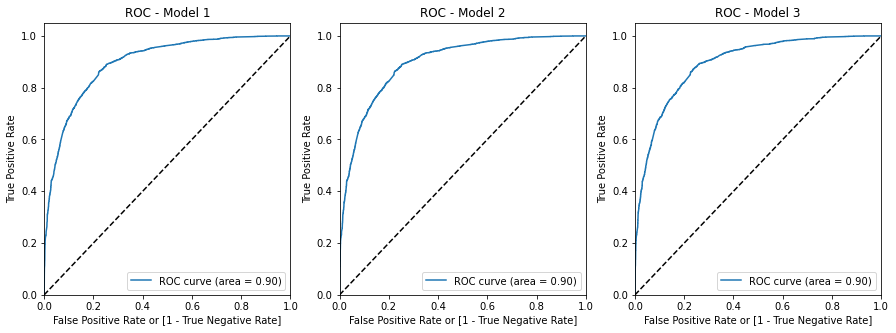

In [74]:
#List of data frames with train data predictions from all models
df_preds = [y_train_pred, y_train_pred2, y_train_pred3]

plt.figure(figsize=(15,5))

i=1

#Iterate through each train data predictions
for df_pre in df_preds:
    plt.subplot(1,3,i)
    actual = df_pre.Converted
    probs = df_pre.Conversion_Prob
    
    #Calculate metrics
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    
    #Plot ROC
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Model '+ str(i))
    plt.legend(loc="lower right")
    i+=1


#### All Models have same Area under curve. They perform almost equally well. 

### 5.2 Compare metrics for all models

In [75]:
#Print all 3 model's metrics for train data with 0.5 cutoff
for i, df_pre in enumerate(df_preds):
    print('Model ' + str(i+1) + ' metrics for train data:')
    calc_metrics(df_pre)
    print()

Model 1 metrics for train data:
 Accuracy : 0.8184322909491666
 Sensitivity: 0.7058610709117221 
 Specificity: 0.8876529477196885 
 Precison: 0.7943811074918566 
 Recall: 0.7058610709117221

Model 2 metrics for train data:
 Accuracy : 0.8180190108830417
 Sensitivity: 0.7047756874095513 
 Specificity: 0.8876529477196885 
 Precison: 0.7941296371789646 
 Recall: 0.7047756874095513

Model 3 metrics for train data:
 Accuracy : 0.8169169307067089
 Sensitivity: 0.7018813314037626 
 Specificity: 0.8876529477196885 
 Precison: 0.7934560327198364 
 Recall: 0.7018813314037626



#### All models performing well with a slight difference in score. However, since Model 1 and 2 has Multi Collinear variables, we will consider Model 3 as our final model.
#### Sensitivity is low for all models, let us see if it improves with changing cutoff

### 5.3. Find Optimal Cutoff for Final Model (Model 3)

In [76]:
# Let's create columns with different probability cutoffs with 0.1 interval
numbers = [float(x)/10 for x in range(10)]

#Make predictions for each cutoff
for i in numbers:
    y_train_pred3[i]= y_train_pred3.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred3.head()

,Converted,Conversion_Prob,LeadNumber,Converted_Pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.504094,658852,1,1,1,1,1,1,1,0,0,0,0
1,0,0.033658,637819,0,1,0,0,0,0,0,0,0,0,0
2,1,0.618694,582133,1,1,1,1,1,1,1,1,0,0,0
3,1,0.789334,651464,1,1,1,1,1,1,1,1,1,0,0
4,0,0.065233,625541,0,1,0,0,0,0,0,0,0,0,0


In [77]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# Indicate what each value represent in confusion matrix to reduce confusion
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

#Probabilities at 0.1 interval to calculate scores
num = [float(x)/10 for x in range(10)]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred3.Converted, y_train_pred3[i] )
    total1=sum(sum(cm1))
    
    #Calculate accuracy, sensitivity and specificity
    accuracy = (cm1[0,0]+cm1[1,1])/total1    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    #Store scores in the main data frame
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    
#Print scores for each cutoff
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.380769  1.000000  0.000000
0.1   0.1  0.638793  0.971418  0.434260
0.2   0.2  0.765946  0.916787  0.673192
0.3   0.3  0.804656  0.872648  0.762848
0.4   0.4  0.814162  0.774240  0.838710
0.5   0.5  0.816917  0.701881  0.887653
0.6   0.6  0.811682  0.638205  0.918354
0.7   0.7  0.790743  0.534370  0.948387
0.8   0.8  0.768150  0.442475  0.968409
0.9   0.9  0.728751  0.307525  0.987764


<Figure size 864x288 with 0 Axes>

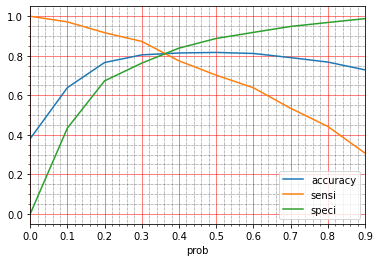

In [78]:
plt.figure(figsize=(12,4))
# Plot accuracy sensitivity and specificity for various probabilities.
fig, ax = plt.subplots()
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], ax=ax)
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

#### From the curve above, probability of 0.36 is the optimum cutoff probability. It is intersection of accuracy, sensitivity and specificity.

In [79]:
#Print metrics for train data with 0.36 cutoff
y_train_pred3 = make_pred(res3, X_train_sm3, y_train, 0.36)
calc_metrics(y_train_pred3)


 Accuracy : 0.8119575699132112
 Sensitivity: 0.8039073806078147 
 Specificity: 0.8169076751946608 
 Precison: 0.7297208538587849 
 Recall: 0.8039073806078147


#### At Optimal cutoff, sensitivity has improved from .7 to .8 and specificity descreased from .88 to .81 which is fine. Our goal is to maximise sensitivity

#### Train Data : At cutoff of 0.36,  Model 3 has a good accuracy, sensitivity and specificity trade off.

### 5.4 Precision and Recall Tradeoff

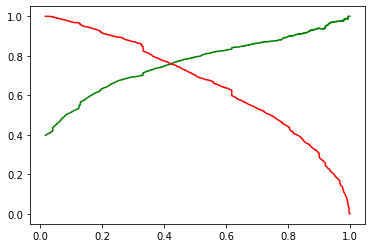

In [80]:
#Plot precision vs recall for model 3 
p, r, thresholds = precision_recall_curve(y_train_pred3.Converted, y_train_pred3.Conversion_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

#### With respect to Precision and Recall, probability close to 0.4 is optimal cutoff probability. However, our goal is to maximise sensitivity as we want to maximise correct positive prediction out of actual predictions. So we will stick to cutoff rate of 0.36

## 6. Predict Values for Test Data

In [81]:
#Scale test data
# Transform continuous numeric columns using the scaler
X_test_data = X_test.copy()
X_test_data[cont_cols] = scaler.transform(X_test[cont_cols])

#### Make predictions on test data using Model 3

In [82]:
#Add constant to test data input
X_test_sm = sm.add_constant(X_test_data[sel_cols3])

#<Make predictions using Model 3
df_test_pred = make_pred(res3, X_test_sm, y_test, 0.36)

#Calculate Scores and pritn them
calc_metrics(df_test_pred)

 Accuracy : 0.8170798898071625
 Sensitivity: 0.789865871833085 
 Specificity: 0.833041958041958 
 Precison: 0.7350901525658807 
 Recall: 0.789865871833085


#### Test Data Prediction Result:

At cutoff of 0.36, Model 3 performed well on test data as it's accuracy is .81 and sensitivity is .79. Hence, this is a good model

## 7. Lead Scores
#### Assign Lead scores based on probabilities to identify Hot Leads

In [83]:
#Make predictions on whole data
X =df_leads.copy()

#Scale whole data
X[cont_cols] = scaler.transform(X[cont_cols])

In [84]:
#Input Features
X = X[sel_cols3]

#Add constnat to features
X_sm = sm.add_constant(X)

#Target variable
y = df_leads['Converted']

In [85]:
#make predictions using model 3. Cutoff doesn't really matter here as we will be using probability to assign score
y_pred = make_pred(res3,X_sm,y,0.36)

#### Make Bins to identify Hot Leads

In [86]:
#Make bins based on predicted probabilities
bins = [0, .2, .4, .6, 1]
labels =[20, 40, 60, 100]

#Divide the data into bins
y_pred['LeadScore'] = pd.cut(y_pred['Conversion_Prob'], bins, labels=labels)

#Print few row from predictions
y_pred.head()

,Converted,Conversion_Prob,LeadNumber,Converted_Pred,LeadScore
0,0,0.125459,660737,0,20
1,0,0.392739,660728,1,40
2,1,0.732066,660727,1,100
3,0,0.063231,660719,0,20
4,1,0.201206,660681,0,40


In [87]:
round(100*y_pred.groupby(by=['LeadScore','Converted']).count()['LeadNumber']
      /y_pred.groupby(by=['LeadScore']).count()['LeadNumber'], 2 )

LeadScore  Converted
20         0            92.78
           1             7.22
40         0            65.26
           1            34.74
60         0            48.38
           1            51.62
100        0            17.23
           1            82.77
Name: LeadNumber, dtype: float64

#### As we can see, leads with a score of 100 results in a conversion rate of 82%. These are our hot leads

### Hot Leads

In [88]:
#Hot Leads are the ones with a Lead Score of 100
hot_leads = y_pred[y_pred.LeadScore == 100]
print('Number of Hot Leads:', len(hot_leads))

Number of Hot Leads: 2618


#### We have around 2600 Hot Leads

## 8. Summary

### 8.1 Interpret the final model

In [89]:
#Print Final Model's Summary. Final model is res3
summary = res3.summary()

#First row in data is for headings
cols = summary.tables[1].data[0]

#Convert Summary to a dataframe to sort it on coefficients for easy interpretation 
summary_df = pd.DataFrame(summary.tables[1].data, columns=cols).drop(0)

#Convert coef to numberic for meaningful sorting
summary_df['coef'] = pd.to_numeric(summary_df['coef'])

In [90]:
#Print variables and coefficients in descending order
summary_df.sort_values(by='coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
19,Source_Welingak Website,5.7059,0.730,7.813,0.000,4.275,7.137
4,TTSW,4.4762,0.160,27.942,0.000,4.162,4.790
18,Source_Reference,3.2321,0.232,13.941,0.000,2.778,3.687
15,Occupation_Working Professional,2.4253,0.184,13.154,0.000,2.064,2.787
13,LastNotableAct_Other,1.8866,0.438,4.312,0.000,1.029,2.744
8,LastActivity_Other,1.7183,0.520,3.306,0.001,0.700,2.737
9,LastActivity_SMS Sent,1.7098,0.106,16.124,0.000,1.502,1.918
10,LastActivity_Unsubscribed,1.5971,0.450,3.546,0.000,0.714,2.480
17,Source_Olark Chat,1.2641,0.122,10.343,0.000,1.025,1.504
3,TotalVisits,1.2617,0.342,3.691,0.000,0.592,1.932


#### Vairables having most positive impact on conversion:
1. Source_Welingak Website
2. Total Time Spent on Website
2. Source_Reference
3. Occupation_Working Professional

#### Vairables having most negative impact on conversion:
1. NoEmail
2. Occupation_Unknown
3. Specialization_Unknown
4. Origin_Landing Page Submission


### 8.2 Hot Leads

In [91]:
#Print Number of Hot Leads
print('Number of Hot Leads:', len(hot_leads))

Number of Hot Leads: 2618


In [92]:
#Print Hot Lead numbers
print('Few Hot Lead numbers:', hot_leads['LeadNumber'].values)

Few Hot Lead numbers: [660727 660673 660608 ... 579622 579564 579533]


#### There are around 2600 hot leads as listed above. If sales team focus on these leads, they would get approximately 83% conversion which is slightly more than the target of 80%. 